#Mega Case Study - Making a hybrid Deep Learning Model

#Part 1 - SOM

##Install MiniSom Package

In [ ]:
!pip install MiniSom

## Importing the libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Machine Learning/Deep Learning A-Z: Hands-On Artificial Neural Networks/Part 4 - Self Organizing Maps/Mega-Case-Study/Credit_Card_Applications.csv')

In [ ]:
dataset = pd.read_csv('Credit_Card_Applications.csv')

In [5]:
dataset

CustomerID  A1     A2      A3  A4  A5  A6     A7  A8  A9  A10  A11  A12  \
0      15776156   1  22.08  11.460   2   4   4  1.585   0   0    0    1    2   
1      15739548   0  22.67   7.000   2   8   4  0.165   0   0    0    0    2   
2      15662854   0  29.58   1.750   1   4   4  1.250   0   0    0    1    2   
3      15687688   0  21.67  11.500   1   5   3  0.000   1   1   11    1    2   
4      15715750   1  20.17   8.170   2   6   4  1.960   1   1   14    0    2   
..          ...  ..    ...     ...  ..  ..  ..    ...  ..  ..  ...  ...  ...   
685    15808223   1  31.57  10.500   2  14   4  6.500   1   0    0    0    2   
686    15769980   1  20.67   0.415   2   8   4  0.125   0   0    0    0    2   
687    15675450   0  18.83   9.540   2   6   4  0.085   1   0    0    0    2   
688    15776494   0  27.42  14.500   2  14   8  3.085   1   1    1    0    2   
689    15592412   1  41.00   0.040   2  10   4  0.040   0   1    1    0    1   

     A13   A14  Class  
0    100  1213      0  
1    160     1      0  
2    280     1      0  
3      0     1      1  
4     60   159      1  
..   ...   ...    ...  
685    0     1      1  
686    0    45      0  
687  100     1      1  
688  120    12      1  
689  560     1      1  

[690 rows x 16 columns]

In [6]:
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

## Feature Scaling


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

##Training the SOM


In [8]:
from minisom import MiniSom

n_rows, n_features = X.shape
x_nodes, y_nodes = 10, 10

som = MiniSom(
    x = x_nodes, 
    y = y_nodes, 
    input_len = n_features, 
    sigma = 1.0, 
    learning_rate = 0.5
)

som.random_weights_init(X)
som.train_random(
    data = X, 
    num_iteration = 100
)

##Visualizing the results


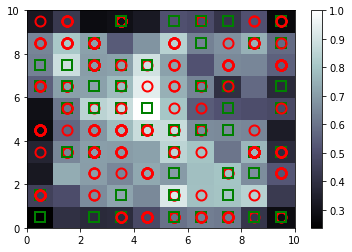

In [9]:
from pylab import bone, pcolor, colorbar, plot, show

bone()
pcolor(som.distance_map().T)
colorbar()

markers = ['o', 's']
colors = ['r', 'g']

for i, x in enumerate(X):
    w = som.winner(x)
    approval_flag = y[i]
    plot(
        w[0] + 0.5,
        w[1] + 0.5,
        marker = markers[approval_flag],
        markeredgecolor = colors[approval_flag],
        markerfacecolor = 'None',
        markersize = 10,
        markeredgewidth = 2
    )

show()

## Finding the frauds


In [10]:
threshold_value = 0.9
map_of_distance = som.distance_map().T
exceed_map = []

for i in range(0, x_nodes):
    for j in range (0, y_nodes):
        if map_of_distance[i, j] >= threshold_value:
            exceed_map.append((i, j))

mappings = som.win_map(X)

mappings_exceed = []
for e in exceed_map:
    mappings_exceed = mappings_exceed + mappings[e]

frauds = sc.inverse_transform(mappings_exceed)

print(exceed_map)

[(1, 5), (5, 4), (6, 4)]


##Printing the Fraunch Clients

In [11]:
print('All fraud Customer IDs:\n', frauds[:, 0])

All fraud Customer IDs:
 [15636767. 15603683. 15659100. 15648681. 15666012. 15716347. 15642448.
 15585855. 15597536. 15661412. 15571284. 15591360. 15570947. 15641715.
 15589881. 15592326. 15671293. 15602456. 15697844. 15675176. 15580579.
 15568819. 15665374. 15598586. 15777994. 15704081. 15677112. 15697310.
 15722479. 15810723. 15730360. 15703177. 15733602. 15706602. 15728082.
 15693382. 15752601. 15632669. 15740356.]


In [12]:
fraudsId = frauds[:, 0]
ds_filt_by_fraud = dataset[dataset.CustomerID.isin(fraudsId)]
ds_filt_by_fraud = ds_filt_by_fraud.filter(items = ['CustomerID', 'Class'])
ds_filt_by_fraud_and_approved = ds_filt_by_fraud[ds_filt_by_fraud.Class == 1]
ds_filt_by_fraud_and_approved = ds_filt_by_fraud_and_approved.CustomerID.to_numpy()

print('Fraud Customer who got approved request IDs:\n', ds_filt_by_fraud_and_approved)

Fraud Customer who got approved request IDs:
 [15777994 15585855 15704081 15677112 15597536 15661412 15659100 15697310
 15571284 15591360 15810723 15730360 15570947 15716347 15641715 15589881
 15592326 15602456 15703177 15697844 15733602 15706602 15728082 15675176
 15568819 15693382 15752601 15665374 15598586 15740356]


#Part 2 - Going from Unsupervised to Supervised Deep Learning

##Create Matrix of Features

In [13]:
# for supervised deep learning we need of a dependent variable

# for the matrix of independent variable we can remove the first column CustomerID because we don't need it in the training 
# but we will include the last one who classify the customer if he got the credit card
customers = dataset.iloc[:, 1:].values

## Create Dependent Variable

In [23]:
# we create the dependent variable that for each ID will contain the information whether it is a fraudulent customer or not, 
# it will be a binary array with 0 (no fraud) and 1 (fraud), we create it based on the "frauds" output vector.

is_fraud = np.zeros(len(dataset))

for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

# alternative version
# potential_cheaters = frauds[:,0]
# is_fraud = dataset['CustomerID'].isin(potential_cheaters).astype(int).values

#Part 3 - ANN

### Feature Scaling

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

## Building the ANN

##Import Tensorflow

In [25]:
import tensorflow as tf
tf.__version__

'2.8.2'

## Initializing the ANN

In [26]:
# in this ANN we can use less layers and less neurons than the ANN model created in the previous section because this problem has less observations
# and it is less complex

ann = tf.keras.models.Sequential()

##Adding the input layer and the first hidden layer

In [27]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

## Adding the output layer

In [28]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the ANN

## Compiling the ANN

In [29]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Training the ANN on the Training set

In [30]:
# now we can start the training passing to the "fit" function: the dataset, the dependent variable vector, the batch size and the number of epochs
ann.fit(customers, is_fraud, batch_size = 1, epochs = 10)

Epoch 1/10
690/690 [==============================] - 1s 1ms/step - loss: 0.8918 - accuracy: 0.5087
Epoch 2/10
690/690 [==============================] - 1s 1ms/step - loss: 0.4899 - accuracy: 0.8681
Epoch 3/10
690/690 [==============================] - 2s 3ms/step - loss: 0.3551 - accuracy: 0.9362
Epoch 4/10
690/690 [==============================] - 2s 3ms/step - loss: 0.2872 - accuracy: 0.9406
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2466 - accuracy: 0.9435
Epoch 6/10
690/690 [==============================] - 1s 1ms/step - loss: 0.2180 - accuracy: 0.9435
Epoch 7/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1969 - accuracy: 0.9435
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.1794 - accuracy: 0.9435
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.1655 - accuracy: 0.9464
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.1539 - accuracy: 0.9493

## Predicting test set results

In [31]:
# the predicted probabilities will be very low because the dependent variable vector contains a few ones
y_pred_prob = ann.predict(customers)

# to get the association, we concatenate the customer IDs with their probabilities
y_pred_id_and_prob = np.concatenate(
    (
        dataset.iloc[:, 0:1].values, # IDs
        y_pred_prob # probabilities
    ), 
    axis = 1
)

# now we want to sort the matrix just created by probabilities, keeping the correlation with each ID
# we can do this using a trick
y_pred_id_and_prob_sort = y_pred_id_and_prob[ # the matrix we want to sort
      y_pred_id_and_prob[:, 1] # the column of the matrix for the sorting
      .argsort() # the sorting method
]

print(y_pred_id_and_prob_sort)

[[1.57761560e+07 5.86249232e-02]
 [1.57961110e+07 5.86249232e-02]
 [1.56460820e+07 5.86249232e-02]
 ...
 [1.55858550e+07 5.27746797e-01]
 [1.55923260e+07 5.67851543e-01]
 [1.55805790e+07 6.93216622e-01]]
